In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rrc import rrc
import yaml

with open("siso_mimo_config.yml","r") as f:
    data = yaml.safe_load(f)

EsN0dB = data['EsN0dB']
EbN0dB = data['EbN0dB']
N0 = data['N0']
EsN0dB_fine = data['EsN0dB_fine']
EbN0dB_fine = data['EbN0dB_fine']
N0_fine = data['N0_fine']
Es = data['symbol_energy']
Rs = data['symbol_rate']
Fs = data['sampling_rate']
sps = Fs/Rs


Impulse reponse of root-raised_cosine (RRC) filter

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


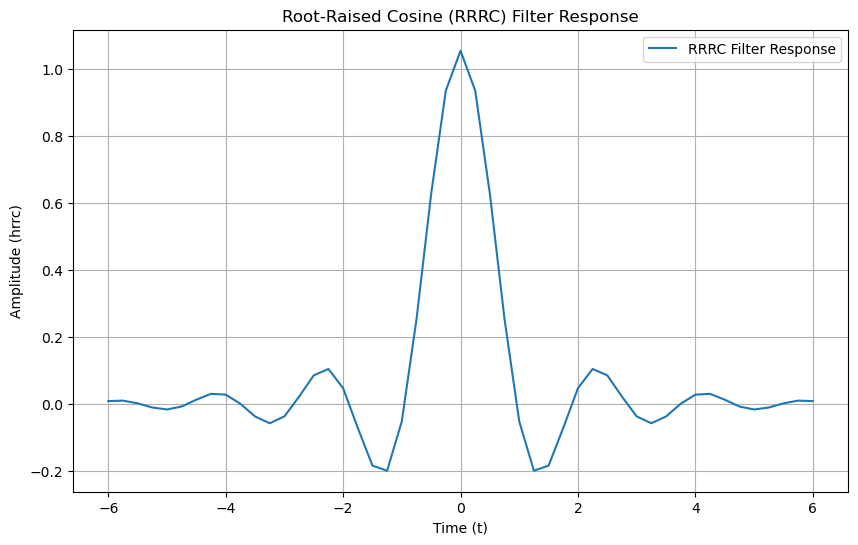

In [3]:
alpha = 0.2  # roll-off factor
T = 1/Rs     # symbol period
t = np.arange(-6,6+1/sps,1/sps)
hrrc = rrc(t,alpha,T)


plt.figure(figsize=(10, 6))
plt.plot(t, hrrc)
plt.title('Impulse Reponse of Root-Raised Cosine (RRC) Filter')
plt.xlabel(r'$t$')
plt.ylabel(r'$h_{rrc}(t)$')
plt.grid(True)
plt.legend()
plt.show()

Nbits = 1e6
